In [2]:
import sys
sys.path.append("..")

In [3]:
import collections

import numpy as np
import matplotlib.pyplot as plt
import pygmsh
import meshio
import pytictoc
import scipy.sparse
import scipy.interpolate
import gmsh

from femns2d import femns2d

In [4]:
def create_rectangle(pfactor=0.2, L=5, name="rectangle.msh"):
    gmsh.initialize()
    gmsh.model.add('rectangle')
    
    # Create points for unit square corners
    gmsh.model.geo.addPoint(0, 0, 0, pfactor, 1)
    gmsh.model.geo.addPoint(L, 0, 0, pfactor, 2)
    gmsh.model.geo.addPoint(L, 1, 0, pfactor, 3)
    gmsh.model.geo.addPoint(0, 1, 0, pfactor, 4)

    # Connect points with lines to form unit square
    gmsh.model.geo.addLine(1, 2, 3) #Lower boundary
    gmsh.model.geo.addLine(2, 3, 2) #Right boundary
    gmsh.model.geo.addLine(3, 4, 4) #Upper boundary
    gmsh.model.geo.addLine(4, 1, 1) #Left boundary

    # Create Curve Loop and Plane Surface
    gmsh.model.geo.addCurveLoop([1, 2, 3, 4], 1)
    gmsh.model.geo.addPlaneSurface([1], 1)

    # Add physical lines for the boundaries
    gmsh.model.geo.addPhysicalGroup(1, [1], 1)
    gmsh.model.geo.addPhysicalGroup(1, [2], 2)
    gmsh.model.geo.addPhysicalGroup(1, [3], 3)
    gmsh.model.geo.addPhysicalGroup(1, [4], 4)    
    # Add physical group for the surface
    gmsh.model.geo.addPhysicalGroup(2, [1], 5)

    # Synchronize model and define mesh size
    gmsh.model.geo.synchronize()

    # Generate 2D mesh
    gmsh.model.mesh.generate(2)

    # Save mesh
    gmsh.write(name)

    gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.00100836s, CPU 0.001741s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0659376s, CPU 0.066449s)
Info    : 1302 nodes 2606 elements
Info    : Writing 'rectangle.msh'...
Info    : Done writing 'rectangle.msh'



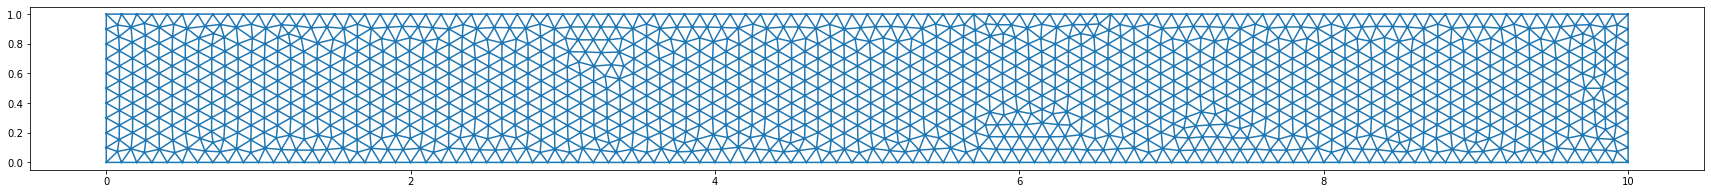

In [36]:
# Read the mesh file
L = 10
domain_length = L
pfactor = 0.1
create_rectangle(pfactor, L)
mesh = meshio.read("rectangle.msh")

# Plot the mesh
fig, ax = plt.subplots(figsize=(L*3, 3))
ax.triplot(mesh.points[:, 0], mesh.points[:, 1], mesh.cells_dict["triangle"])

plt.show()

In [37]:
FARADAY = 96485.3321 #C/mol
INCURRENT = 10*1e4*1e-3 #mA/cm^2 to C/(s*m^2)
FLUX_SCALE = INCURRENT/FARADAY #mol/(s*m^2)
DIFFUSION_SCALE = 6*1e-11 #mol/m^2
LENGTH_SCALE = 150*1e-6/domain_length #m
TIME_SCALE = LENGTH_SCALE**2/DIFFUSION_SCALE #s
CONCENTRATION_SCALE = FLUX_SCALE*LENGTH_SCALE/DIFFUSION_SCALE #mol/m^3
AREA_CONCENTRATION_SCALE = FLUX_SCALE*LENGTH_SCALE**2/DIFFUSION_SCALE #mol/m^2
KAPPA_SCALE = 1/(CONCENTRATION_SCALE*TIME_SCALE) #1/((mol/m^3)*s)
AVOGRADO = 6.02214076*1e23 #1/mol

# Print values with names
print(f"FLUX_SCALE = {FLUX_SCALE} mol/(m^2 s)")
print(f"DIFFUSION_SCALE = {DIFFUSION_SCALE} mol/m^2")
print(f"LENGTH_SCALE = {LENGTH_SCALE} m")
print(f"TIME_SCALE = {TIME_SCALE} s")
print(f"CONCENTRATION_SCALE = {CONCENTRATION_SCALE} mol/m^3")
print(f"AREA_CONCENTRATION_SCALE = {AREA_CONCENTRATION_SCALE} mol/m^2")
print(f"KAPPA_SCALE = {KAPPA_SCALE} 1/((mol/m^3)*s)")

FLUX_SCALE = 0.0010364269658766092 mol/(m^2 s)
DIFFUSION_SCALE = 6e-11 mol/m^2
LENGTH_SCALE = 1.4999999999999999e-05 m
TIME_SCALE = 3.7499999999999996 s
CONCENTRATION_SCALE = 259.10674146915227 mol/m^3
AREA_CONCENTRATION_SCALE = 0.0038866011220372843 mol/m^2
KAPPA_SCALE = 0.0010291768757333336 1/((mol/m^3)*s)


In [41]:
6*1e19/AVOGRADO/(AREA_CONCENTRATION_SCALE), 1e-23*AVOGRADO/KAPPA_SCALE

(0.02563482613780685, 5851.4147587206135)

In [42]:
assembler = femns2d.MiniAssembler(mesh)
assembler.set_main_element("linear")
assembler.set_line_elements()

In [43]:
#Set forcing function
lower_boundary_line_elements = np.isclose(assembler.points[assembler.line_elements, :].mean(axis=1)[:, 1], 0)
left_boundary_line_elements = np.isclose(assembler.points[assembler.line_elements, :].mean(axis=1)[:, 0], 0)

In [44]:
LEFT_BOUNDARY = 1
RIGHT_BOUNDARY = 2
UPPER_BOUNDARY = 4
LOWER_BOUNDARY = 3

left_flux = 1
left_boundary_forcing = np.zeros(assembler.line_elements.shape[0])
left_boundary_forcing[left_boundary_line_elements] = left_flux
left_boundary_forcing_f = assembler.line_forcing_vector(lambda i : left_boundary_forcing[i],
                                                        forcing_fn_type='element')

kappa = 0.01
nfree = 100.0
base_sink_boundary_forcing = np.zeros(assembler.line_elements.shape[0])
base_sink_boundary_forcing[lower_boundary_line_elements] = -kappa*nfree


dirichlet_bcs = [[0], [RIGHT_BOUNDARY]]
dt = 0.01
tmax = 1000
steps = int(tmax/dt)

In [45]:
3*np.log(3)/(2*np.pi)

0.5245487288490897

In [ ]:
K = assembler.stiffness_matrix(stiffness_fn=1.0)
M = assembler.mass_matrix()
MKdt = M + dt*K
MKdt = assembler.apply_dirichlet_to_matrix(dirichlet_bcs[1], MKdt, where='u')
    
Tvalues = []
T = np.zeros(assembler.nvariables)
T = assembler.apply_dirichlet_to_vector(*dirichlet_bcs, T, where='u')
Tvalues.append(T.copy())
T_lines = T[assembler.line_elements].mean(axis=-1)

MKdt = MKdt.tocsc()
LU = scipy.sparse.linalg.splu(MKdt)


for i in range(steps):
    f = M@T + dt*left_boundary_forcing_f
    sink_boundary_forcing = base_sink_boundary_forcing*T_lines
    sink_boundary_forcing_f = assembler.line_forcing_vector(lambda i : sink_boundary_forcing[i],
                                                            forcing_fn_type='element')
    f += dt*sink_boundary_forcing_f
    f = assembler.apply_dirichlet_to_vector(*dirichlet_bcs, f, where='u')
    MKdt = MKdt.tocsc()
    T = LU.solve(f)
    T_lines = T[assembler.line_elements].mean(axis=-1)
    base_sink_boundary_forcing *= np.exp(-kappa*T_lines*dt)
    Tvalues.append(T.copy())
t = np.arange(steps+1)*dt
T = np.array(Tvalues)
    

In [ ]:
right_boundary_line_elements = np.isclose(assembler.points[assembler.line_elements, :].mean(axis=1)[:, 0], L)
right_boundary_elements = np.hstack([assembler.line_elements_to_elements[tuple(l)]
                                     for l in assembler.line_elements[right_boundary_line_elements]])
Tupper = [Ti[assembler.line_elements[right_boundary_line_elements]].mean() for Ti in T]
flux_upper = [-assembler.get_linear_element_equation(Ti)[right_boundary_elements, 0].mean() for Ti in T]

In [ ]:
plt.plot(t, flux_upper)

In [ ]:
Ti = T[20]
plt.figure(figsize=(3*L, 3))
plt.triplot(assembler.points[:, 0], assembler.points[:, 1], assembler.elements, alpha=0.2)
plt.scatter(assembler.points[:, 0], assembler.points[:, 1], c=Ti)
plt.colorbar()

Text(0, 0.5, 'y')

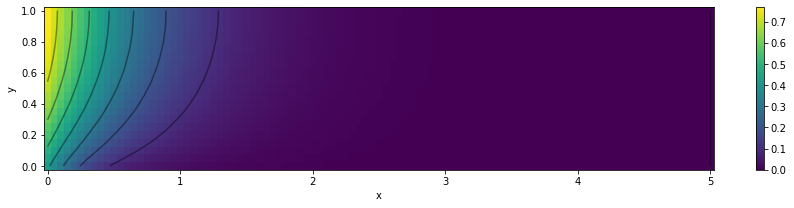

In [164]:
Ti = T[80]
Tinterp = scipy.interpolate.LinearNDInterpolator(assembler.points[:, :-1], Ti)
X, Y = np.meshgrid(np.linspace(0, L, (20*L+1)), np.linspace(0, 1, (20+1)))
Z = Tinterp(X, Y)
plt.figure(figsize=(3*L,3))
plt.pcolormesh(X, Y, Z, shading="auto")
plt.colorbar()
plt.contour(X, Y, Z, colors='black', alpha=0.4)
plt.xlabel("x")
plt.ylabel("y")

In [110]:
plt.contour?